In [ ]:
#Classification Workflow of Ponds in UK

# Classification Workflow of Lakes & Ponds in UK

# Connecting with Google drive


In [1]:
#road changed as gdrive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My\ Drive/same\ trial

/content/gdrive/My Drive/same trial


In [3]:
!ls /content/gdrive/My\ Drive/same\ trial

 3_channels_2classes_b4_s32_a025_g2_68.sav   model_store  'train data'
 Ghana					     Tools	   Unet


In [ ]:
#with open('/content/gdrive/My Drive/foo1.txt', 'w') as f:
#  f.write('Testing the position in google drive')
#!cat /content/gdrive/My\ Drive/foo.txt
# a text on where my work directory

# Preprocessing and loading data



In [4]:
#store path is changed
import sys
sys.path.append('/content/gdrive/My\ Drive/same\ trial')
print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/gdrive/My\\ Drive/same\\ trial']


In [5]:
!ls /content/gdrive/My\ Drive/same\ trial

 3_channels_2classes_b4_s32_a025_g2_68.sav   model_store  'train data'
 Ghana					     Tools	   Unet


In [6]:
import warnings
warnings.filterwarnings("ignore")


import os
import math
import scipy.io
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from osgeo import gdal
from osgeo import gdal_array
from natsort import natsorted
%matplotlib inline

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


In [7]:
from Tools import preprocessor as pr
import imp
imp.reload(pr)

<module 'Tools.preprocessor' from '/content/gdrive/My Drive/same trial/Tools/preprocessor.py'>

In [8]:
import torch
from torch.utils import data
from tqdm.notebook import tqdm

from Unet import customdataset as csd
from Unet import Fri_unet
#imp.reload(csd)
#imp.reload(Fri_unet)

In [ ]:
#path has changed

label_path = '/content/gdrive/My Drive/same trial/train data/Thr_Labels_final'

input_path = '/content/gdrive/My Drive/same trial/train data/Bigger_Set_21_19_HistMatch'


Y, X_3 = pr.create_model_dataset(label_path, input_path, 3, 2)

Y, X_6 = pr.create_model_dataset(label_path, input_path, 6, 2)

Y, X_10 = pr.create_model_dataset(label_path, input_path, 10, 2)
####?? my explaination,two numbers input class, could be add, like 3 class as lake, river and land.

ZeroDivisionError: ignored

#Splitting the Dataset

In [ ]:
from sklearn.model_selection import train_test_split

random_seed = 42

# split dataset into training set and validation set
train_size = 0.7  # 70:30 split

#first set with 3 bands
inputs_train, inputs_valid = train_test_split(
    X_3, random_state=random_seed, train_size=train_size, shuffle=True
)

targets_train, targets_valid = train_test_split(
    Y, random_state=random_seed, train_size=train_size, shuffle=True
)

In [ ]:
#split validation dataset further to create a testing set
valid_size = 0.7

inputs_valid, inputs_test = train_test_split(inputs_valid,random_state=random_seed, train_size= valid_size, shuffle=True
)

targets_valid, targets_test = train_test_split(targets_valid, random_state=random_seed, train_size= valid_size, shuffle=True
)

print('Input data split ', inputs_train.shape, inputs_valid.shape, inputs_test.shape)
print('Target data split ', targets_train.shape, targets_valid.shape, targets_test.shape)

Input data split  (1381, 3, 64, 64) (414, 3, 64, 64) (178, 3, 64, 64)
Target data split  (1381, 64, 64) (414, 64, 64) (178, 64, 64)


In [ ]:
from torch.utils.data import DataLoader

# dataset training
training_dataset = csd.SegmentationDataSet1(inputs=inputs_train,
                                targets=targets_train,
                                transform=None)

# training dataloader
dataloader_training = DataLoader(dataset=training_dataset,
                                      batch_size=2,
                                      shuffle=True)
# dataset validation
dataset_valid = csd.SegmentationDataSet1(
    inputs=inputs_valid, targets=targets_valid, transform=None
)

# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid, batch_size=2, shuffle=True)

# dataset_testing
testing_dataset = csd.SegmentationDataSet1(inputs=inputs_test,
                                targets=targets_test,
                                transform=None)
# dataloader_testing
dataloader_testing = DataLoader(dataset = testing_dataset, batch_size =2, shuffle = True)

x, y = next(iter(dataloader_training))
print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')


x = shape: torch.Size([2, 3, 64, 64]); type: torch.float32
x = min: 0.03529411926865578; max: 0.34117648005485535
y = shape: torch.Size([2, 64, 64]); class: tensor([0, 1]); type: torch.int64


# Building a U-net and tuning hyperparameters via for loops


  
        The Hyperparameters were choosen experimentally.
        First stage was building a model with standard combination:
        * Alpha = 0.25
        * Gamma = 2
        * Blocks = 3
        * Start Filters = 32
        * Learning Rate = 0.01
      
        Then , hyperparameters a range of hyperparameters were tested and models were saved only if F1 score was higher then in standart
         combination. In most cases the standart combination yielded best results with only learning rate exeption -
         (beter scores with 0.001 than 0.01)
      

In [ ]:
Fri_unet.compute_max_depth(64)

Level 1: 32.0
Level 2: 16.0
Level 3: 8.0
Level 4: 4.0
Level 5: 2.0
Max-level: 5


[64, 32.0, 16.0, 8.0, 4.0, 2.0]

In [ ]:
from sklearn.metrics import f1_score
from Unet import trainer as tr



from Unet import focal

preprocess = pr.preprocess
postprocess = pr.postprocess

#results = []
#blocks = [2, 3, 4]
#start_filters = [16, 32, 64]
#alpha = [0.25, 0.5, 0.75]
#gamma = [ 2, 5, 8]

#for b in blocks:
#  for s in start_filters:
#    for l in lr:
#      for a in alpha:
#        for g in gamma:

# device
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

# model
model = Fri_unet.UNet(in_channels= 3,
             out_channels=2,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).to(device)

# criterion
criterion = focal.FocalLoss(alpha = 0.25, gamma =2)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# trainer
trainer = tr.Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_dataloader=dataloader_training,
                  validation_dataloader=dataloader_validation,
                  lr_scheduler=None,
                  epochs=12,
                  epoch=0,
                  notebook=True)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()

          #if f1 >=77:
          #  print('Saving Model')
          #  filename = '10channels_4_classes_b' + str(b) + '_s' + str(s) + '_a' + str(a)[2:] + '_g' + str(g) + '.sav'
          #  pickle.dump(model, open(filename, 'wb'))
          #else:
           # print('Model is not good enough')


Progress:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

Training:   0%|          | 0/691 [00:00<?, ?it/s]

Validation:   0%|          | 0/207 [00:00<?, ?it/s]

In [ ]:
preds = np.array([Fri_unet.predict(img, model, preprocess, postprocess, device) for img in inputs_test])
mse = np.square(np.subtract(targets_test, preds)).mean()
f1 =  f1_score(targets_test.reshape(178 * 64*64), preds.reshape(178 * 64*64), average= None)
print(mse, f1)

0.221948516502809 [0.8536498 0.5408997]


In [ ]:
print(round(np.average(f1),2))

0.7


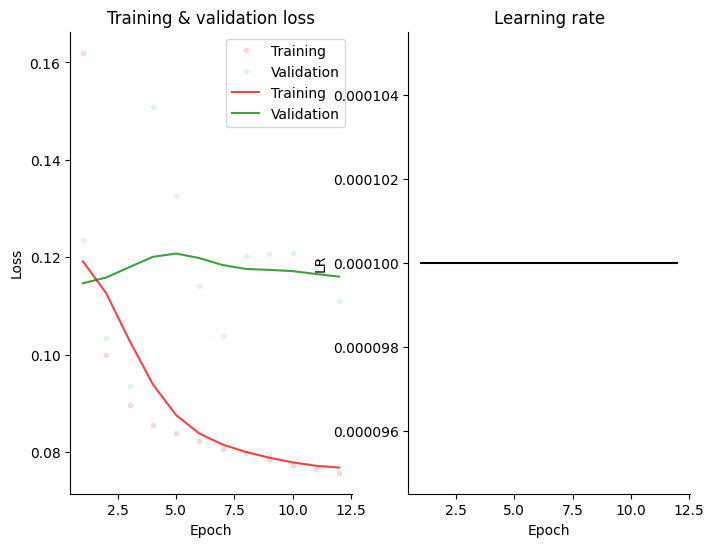

In [ ]:
#import trainer
#imp.reload(trainer)
fig = tr.plot_training(training_losses,
    validation_losses,
    lr_rates,
    gaussian=True,
    sigma=2,
    figsize=(8, 6))

# Saving Model and Reloading to check that F-1 scores are the same

In [ ]:
import pickle
filename = '3_channels_2classes_b4_s32_a025_g2_xx.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
#import pickle
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score





#filename = '3_channels_2classes_b4_s32_a025_g2_xx.sav'
#pickle.dump(model, open(filename, 'wb'))

preprocess = pr.preprocess
postprocess = pr.postprocess

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

import sys
sys.path.append(r'/content/gdrive/My Drive/same trial')
with open('/content/gdrive/My Drive/same trial/3_channels_2classes_b4_s32_a025_g2_xx.sav', 'rb') as fs:
            loaded_model = pickle.load(fs)

# load the model from disk
#loaded_model = pickle.load(open('/content/gdrive/My Drive/sme trial/model_store/3_channels_2classes_b4_s32_a025_g2_xx.sav', 'rb'))
preds = np.array([Fri_unet.predict(img, loaded_model, preprocess, postprocess, device) for img in inputs_test])
ba = balanced_accuracy_score(targets_test.reshape( 178* 64*64), preds.reshape(178 * 64*64))
f1 =  f1_score(targets_test.reshape(178 * 64*64), preds.reshape(178 * 64*64), average= None)
print(ba, f1)

0.7065397844184276 [0.8536498 0.5408997]


<Axes: >

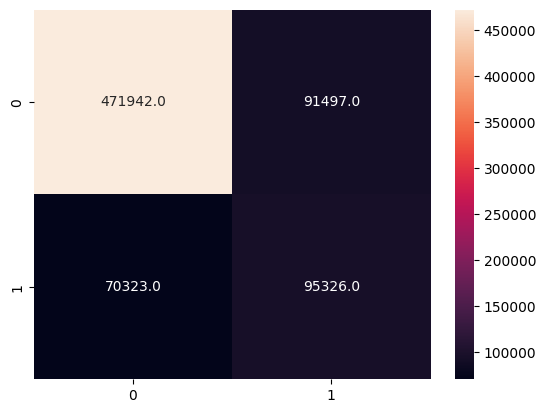

In [ ]:
#Plotting confusion matrix to calculate comission and omission errors
from sklearn.metrics import confusion_matrix
import seaborn as sn
cm = confusion_matrix(targets_test.reshape(178*64*64), preds.reshape(178 *64*64))
sn.heatmap(cm, annot = True, fmt=".1f")

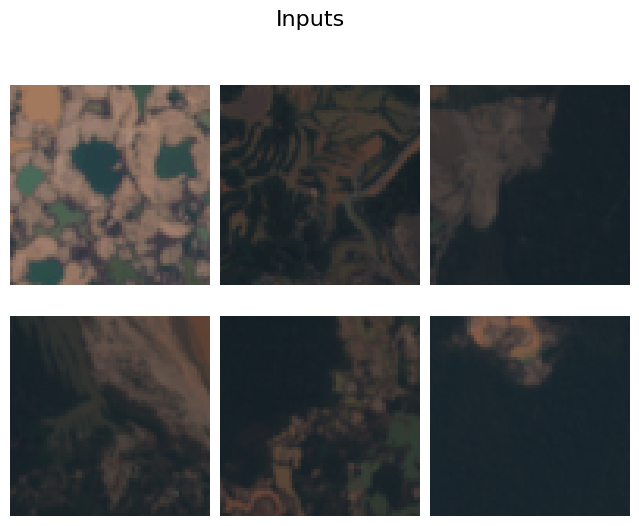

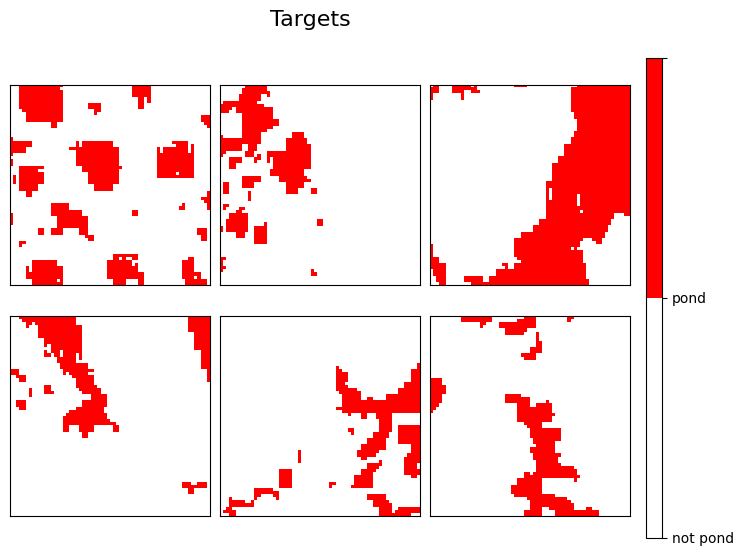

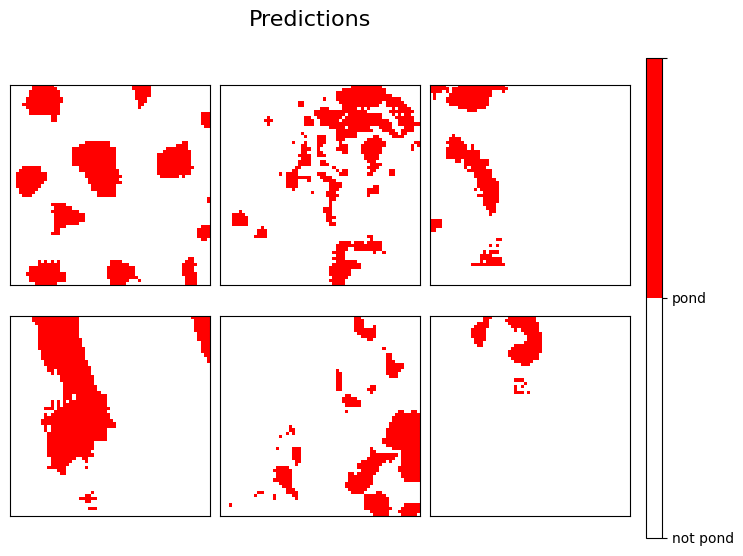

In [ ]:
from Tools import visualizer as viz
imp.reload(viz)
viz.visualise_results(inputs_test,  preds, 2, 28
                      , targets_test)
## 2 is channel, 13 is position & location(?-28---- every 6 to roll the image

# Using Models on data from

In [41]:
from Tools import ghana as gn
path = '/content/gdrive/My Drive/same trial/Ghana'
chanels = 10
ghana_images = gn.open_ghana_images(path, chanels )
input_path = '/content/gdrive/My Drive/same trial/train data/Bigger_Set_21_19_HistMatch'


In [43]:
import pickle
from Unet import Fri_unet
sys.path.append(r'/content/gdrive/My Drive/same trial/Unet')
with open('/content/gdrive/My Drive/same trial/Unet/10_channels_2classes_b3_s32_a06_g2_94.sav', 'rb') as fs:
            loaded_model = pickle.load(fs)

t1_inputs, t1_preds, ferric_iron_t1 = gn.ghana_analyser(ghana_images[5], input_path, 25, 10, loaded_model)
#dawusaso_inputs, dawusaso_preds, ferric_iron_dawusaso = gn.ghana_analyser(ghana_images[1], input_path, 42, 3, loaded_model)
#hun_inputs, hun_preds, ferric_iron_hun = gn.ghana_analyser(ghana_images[2], input_path, 42, 3, loaded_model)
#nkwanta_inputs, nkwanta_preds, ferric_iron_nkwanta = gn.ghana_analyser(ghana_images[3], input_path, 42, 3, loaded_model)

# 42 is position, tune it would change image color(55 failed). 3 is channel

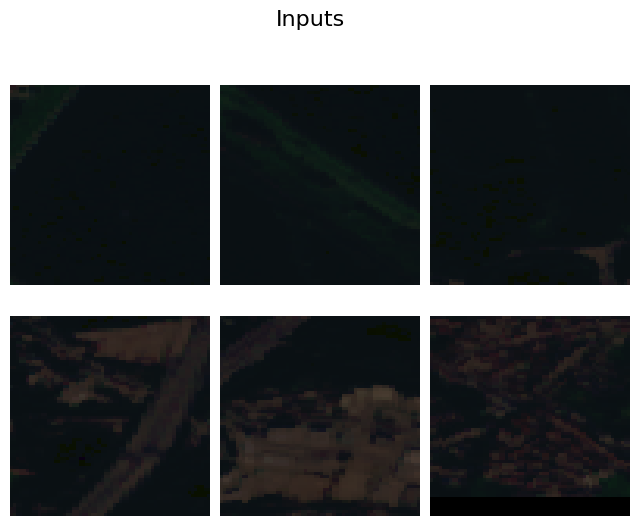

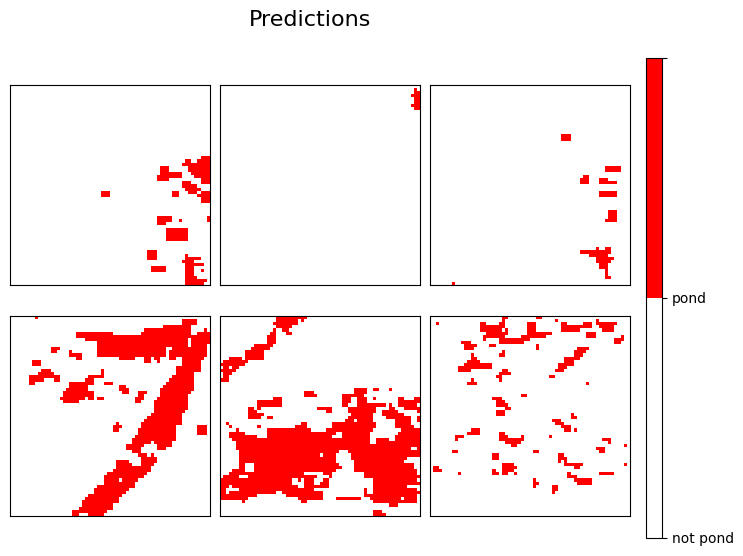

In [44]:
from Tools import visualizer as viz
viz.visualise_results(t1_inputs, t1_preds, 2, 4)
#2 is class number, 3 is image position(0-7)--- every 6 to roll the image